### A Look at the Data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import seaborn as  sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import preprocessing,model_selection,neighbors,svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from catboost import CatBoostClassifier,CatBoostRegressor,cv,Pool
from tqdm import tqdm as tqdm

In [70]:
#!pip install catboost

In [4]:
# read data file
path = "input v3.xlsx"
data=pd.read_excel(path,sheet_name="data")
data.head()

,Date,Cylindrical Sale,Bulk Sale,Autogas Sale,Limit,TUPRAS Price Change TL/ton,TUPRAS Price (OTV+Gelir),Year,Month,Weekday,Special_Day_Type_Holiday,Special_Day_Type_Month,Special_Day_Type_Raise,Special_Day_Type_Discount,Covid Cases,Covid Deaths,Death/recovering
0,2020-06-01,729.273,5.961,171.280,0.000000,0.00000,3461.61,2020,6,2,0,A0,Z-2,0,827,23,0.023614
1,2020-06-02,712.024,7.134,657.056,0.054786,293.10305,3461.61,2020,6,3,0,A+1,Z-1,0,786,22,0.022587
2,2020-06-03,187.235,10.074,375.137,0.000000,0.00000,3752.43,2020,6,4,0,0,Z,0,867,24,0.025779
3,2020-06-04,303.234,3.724,422.513,0.000000,0.00000,3752.43,2020,6,5,0,0,Z+1,0,988,21,0.022678
4,2020-06-05,288.031,2.225,578.255,0.000000,0.00000,3752.43,2020,6,6,0,0,0,0,930,18,0.011097


In [5]:
data.set_index("Date",inplace=True)

In [6]:
data.describe()

,Cylindrical Sale,Bulk Sale,Autogas Sale,Limit,TUPRAS Price Change TL/ton,TUPRAS Price (OTV+Gelir),Year,Month,Weekday,Covid Cases,Covid Deaths,Death/recovering
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,355.842868,11.270297,466.285034,0.001859,14.695136,5481.855195,2020.655932,7.322034,3.994915,1173.496610,134.759322,0.017874
std,203.927576,22.357177,151.517839,0.011532,170.440652,1949.123894,0.513244,3.314529,2.000418,1430.686617,89.021809,0.014506
min,0.000000,0.000000,40.151000,-0.069987,-2861.644100,3461.610000,2020.000000,1.000000,1.000000,0.000000,14.000000,0.003964
25%,268.809250,2.965500,387.459000,0.000000,0.000000,4466.280000,2020.000000,5.000000,2.000000,0.000000,59.000000,0.007843
50%,392.414000,7.351500,475.101500,0.000000,0.000000,4467.260000,2021.000000,8.000000,4.000000,854.000000,128.500000,0.012022
75%,469.498000,12.551500,560.083250,0.000000,0.000000,5852.940000,2021.000000,10.000000,6.000000,1558.750000,203.750000,0.019947
max,1122.743000,284.016000,1102.172000,0.111272,1174.656150,11681.180000,2022.000000,12.000000,7.000000,7381.000000,394.000000,0.070107


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 590 entries, 2020-06-01 to 2022-01-11
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cylindrical Sale             590 non-null    float64
 1   Bulk Sale                    590 non-null    float64
 2   Autogas Sale                 590 non-null    float64
 3   Limit                        590 non-null    float64
 4   TUPRAS Price Change  TL/ton  590 non-null    float64
 5   TUPRAS Price (OTV+Gelir)     590 non-null    float64
 6   Year                         590 non-null    int64  
 7   Month                        590 non-null    int64  
 8   Weekday                      590 non-null    int64  
 9   Special_Day_Type_Holiday     590 non-null    object 
 10  Special_Day_Type_Month       590 non-null    object 
 11  Special_Day_Type_Raise       590 non-null    object 
 12  Special_Day_Type_Discount    590 non-null    object 
 13  C

In our dataset we 4 catecorical features: 

Special_Day_Type_Holiday: categorization of national and religious holidays in Turkey. 

Categorical Variable Explanation for the national amd religious days in Turkey:
Y-1:	Previous Day of the new year,
Y:	    New year ,
Y+1: 	The day after new year,
T:  	National sovereign and children's day,Labor and Solidarity day,Commemoration of Atatürk, Youth and Sports Day,Democracy Day,Victory day,       Republic Day,
RBA:	The day before aid-al-fitr,
RB1:	 aid-al-fitr day 1,
RB2:	 aid-al-fitr day 2,
RB3:	 aid-al-fitr day 3,
KBA:	The day before aid-al-adha,
KB1:	aid-al-adha day 1,
KB2:	aid-al-adha day 2,
KB3:	aid-al-adha day 3,
KB4:	aid-al-adha day 4,
RBA-2:	Three days before the aid-al-fitr,
RBA-1:	Two days before the aid-al-fitr,
RB+1:	The day after the aid-al-fitr,
RB+2:	Two days after the aid-al-fitr,
KBA-2:	Three days before the aid-al-adha,
KBA-1:	Two days before the aid-al-adha,
KB+1:	The day after the aid-al-adha,
KB+2:	Two days after the aid-al-adha.

In [8]:
data.columns

Index(['Cylindrical Sale', 'Bulk Sale', 'Autogas Sale', 'Limit',
       'TUPRAS Price Change  TL/ton', 'TUPRAS Price (OTV+Gelir)', 'Year',
       'Month', 'Weekday', 'Special_Day_Type_Holiday',
       'Special_Day_Type_Month', 'Special_Day_Type_Raise',
       'Special_Day_Type_Discount', 'Covid Cases', 'Covid Deaths',
       'Death/recovering'],
      dtype='object')

In [23]:
data["Autogas-7"] = data["Autogas Sale"].shift(7)
data["Autogas-1"] = data["Autogas Sale"].shift(1)


data["Cylindrical-7"] = data["Cylindrical Sale"].shift(7)
data["Cylindrical-1"] = data["Cylindrical Sale"].shift(1)

data["Bulk-7"] = data["Bulk Sale"].shift(7)
data["Bulk-1"] = data["Bulk Sale"].shift(1)


In [81]:
data["Weekday"]= data["Weekday"].astype('category',copy=False)

In [10]:
data.dropna(inplace=True)

In [11]:
data.tail()

,Cylindrical Sale,Bulk Sale,Autogas Sale,Limit,TUPRAS Price Change TL/ton,TUPRAS Price (OTV+Gelir),Year,Month,Weekday,Special_Day_Type_Holiday,...,Special_Day_Type_Discount,Covid Cases,Covid Deaths,Death/recovering,Autogas-7,Autogas-1,Cylindrical-7,Cylindrical-1,Bulk-7,Bulk-1
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-07,517.221,15.865,436.051,0.000000,0.00000,11681.18,2022,1,6,0,...,0,0,157,0.005377,770.467,365.679,766.497,268.288,256.534,13.983
2022-01-08,133.840,13.007,438.504,0.000000,0.00000,11681.18,2022,1,7,0,...,0,0,141,0.004076,162.655,436.051,3.328,517.221,2.736,15.865
2022-01-09,0.406,0.000,349.366,0.000000,0.00000,11681.18,2022,1,1,0,...,0,0,173,0.004920,253.093,438.504,3.231,133.840,0.000,13.007
2022-01-10,527.552,7.835,644.886,0.000000,0.00000,11681.18,2022,1,2,0,...,0,0,173,0.004920,352.115,349.366,230.438,0.406,12.601,0.000
2022-01-11,499.957,7.510,496.066,0.030677,453.45555,11681.18,2022,1,3,0,...,0,0,173,0.004920,358.087,644.886,255.785,527.552,19.175,7.835


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 583 entries, 2020-06-08 to 2022-01-11
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cylindrical Sale             583 non-null    float64
 1   Bulk Sale                    583 non-null    float64
 2   Autogas Sale                 583 non-null    float64
 3   Limit                        583 non-null    float64
 4   TUPRAS Price Change  TL/ton  583 non-null    float64
 5   TUPRAS Price (OTV+Gelir)     583 non-null    float64
 6   Year                         583 non-null    int64  
 7   Month                        583 non-null    int64  
 8   Weekday                      583 non-null    int64  
 9   Special_Day_Type_Holiday     583 non-null    object 
 10  Special_Day_Type_Month       583 non-null    object 
 11  Special_Day_Type_Raise       583 non-null    object 
 12  Special_Day_Type_Discount    583 non-null    object 
 13  C

In [13]:
X_num = data._get_numeric_data()
X_cat = data.select_dtypes(include=["object"])

In [14]:
X_cat_copy= X_cat.copy()
for col in X_cat.columns:
    X_cat_col=pd.get_dummies(X_cat[col],prefix=col,prefix_sep="_",dummy_na=False,drop_first=True)
    X_cat = pd.concat([X_cat.drop(col,axis=1),X_cat_col],axis=1)

In [15]:
X_cat.shape

(583, 32)

In [16]:
X_cat.head()

,Special_Day_Type_Holiday_KB+1,Special_Day_Type_Holiday_KB+2,Special_Day_Type_Holiday_KB1,Special_Day_Type_Holiday_KB2,Special_Day_Type_Holiday_KB3,Special_Day_Type_Holiday_KB4,Special_Day_Type_Holiday_KBA,Special_Day_Type_Holiday_KBA-1,Special_Day_Type_Holiday_KBA-2,Special_Day_Type_Holiday_RB+1,...,Special_Day_Type_Month_A-1,Special_Day_Type_Month_A0,Special_Day_Type_Raise_Z,Special_Day_Type_Raise_Z+1,Special_Day_Type_Raise_Z-1,Special_Day_Type_Raise_Z-2,Special_Day_Type_Discount_I,Special_Day_Type_Discount_I+1,Special_Day_Type_Discount_I-1,Special_Day_Type_Discount_I-2
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = pd.concat([X_num,X_cat], axis=1)
y = data['Autogas Sale']

What is the relationship between otogas sales and the discount type, also does the discount or increase effect the sale quantity? 

<AxesSubplot:ylabel='Special_Day_Type_Discount'>

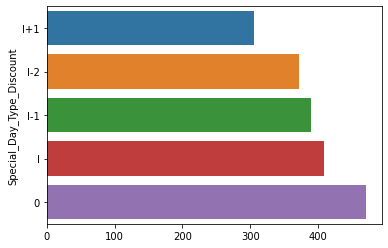

In [37]:
series1 = data.groupby("Special_Day_Type_Discount").mean()['Autogas Sale'].sort_values()
sns.barplot(x=series1.values,y=series1.index)

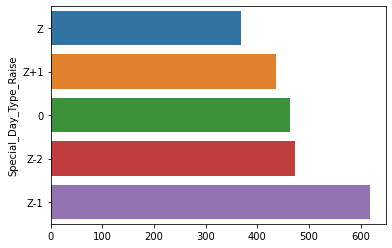

In [38]:
series2 = data.groupby("Special_Day_Type_Raise").mean()['Autogas Sale'].sort_values()
sns.barplot(x=series2.values,y=series2.index);

When we look at the mean otogas sales , we see that there is a relationship between otogas sales and discount. Obviously consumers mostly  buy  otogas in the discount day and the day after 

As opposed to the relationship with discount , consumers buy more otogas before the increase 

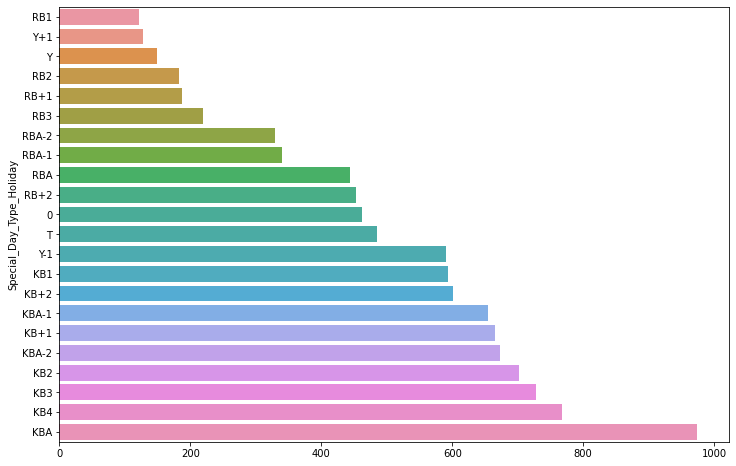

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
series3 = data.groupby(["Special_Day_Type_Holiday"]).mean()['Autogas Sale'].sort_values()
sns.barplot(x=series3.values,y=series3.index);

When we analyze the results we observe that consumers have a tendency to buy more otogas before the feast of Eid-al-Adha holiday. Eid-al-Adha holiday is 4  days in Turkey and the day before the Eid-al-Adha holiday is curucial.Demand during the Eid-al-Adhae holiday is really low compared to the normal days.We see that a scenario similar to Eid-al-Adha is also valid for Eid-al-Fitr. While sales are above normal in the first two days before Eid al-Fitr, a dramatic decrease is observed in sales during the Eid-al-Fitr holiday. Although the sales amount is not as much as the sales before Eid-al-Adha and Eid-al-Fitr holiday, an increase in sales is clearly seen before the new year.

In [62]:
data.Special_Day_Type_Holiday.value_counts()

0        546
T          9
KBA        2
KB1        2
KB2        2
KB3        2
KB4        2
KB+1       2
KB+2       2
Y          2
RB2        1
KBA-2      1
RB+2       1
RB+1       1
RB3        1
Y+1        1
RB1        1
RBA        1
RBA-1      1
RBA-2      1
Y-1        1
KBA-1      1
Name: Special_Day_Type_Holiday, dtype: int64

In [74]:
data[data.Special_Day_Type_Holiday==0].head()

,Cylindrical Sale,Bulk Sale,Autogas Sale,Limit,TUPRAS Price Change TL/ton,TUPRAS Price (OTV+Gelir),Year,Month,Weekday,Special_Day_Type_Holiday,...,Special_Day_Type_Discount,Covid Cases,Covid Deaths,Death/recovering,Autogas-7,Autogas-1,Cylindrical-7,Cylindrical-1,Bulk-7,Bulk-1
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-08,404.246,5.650,533.995,0.0,0.0,3752.43,2020,6,2,0,...,0,989,19,0.005570,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09,378.589,6.695,515.611,0.0,0.0,3752.43,2020,6,3,0,...,0,993,18,0.005594,NaN,533.995,NaN,404.246,NaN,5.650
2020-06-10,380.192,4.372,575.367,0.0,0.0,3752.43,2020,6,4,0,...,0,922,17,0.007586,NaN,515.611,NaN,378.589,NaN,6.695
2020-06-11,376.201,5.037,538.706,0.0,0.0,3752.43,2020,6,5,0,...,0,987,17,0.016650,NaN,575.367,NaN,380.192,NaN,4.372
2020-06-12,407.578,1.001,604.258,0.0,0.0,3752.43,2020,6,6,0,...,0,1195,15,0.012077,NaN,538.706,NaN,376.201,NaN,5.037


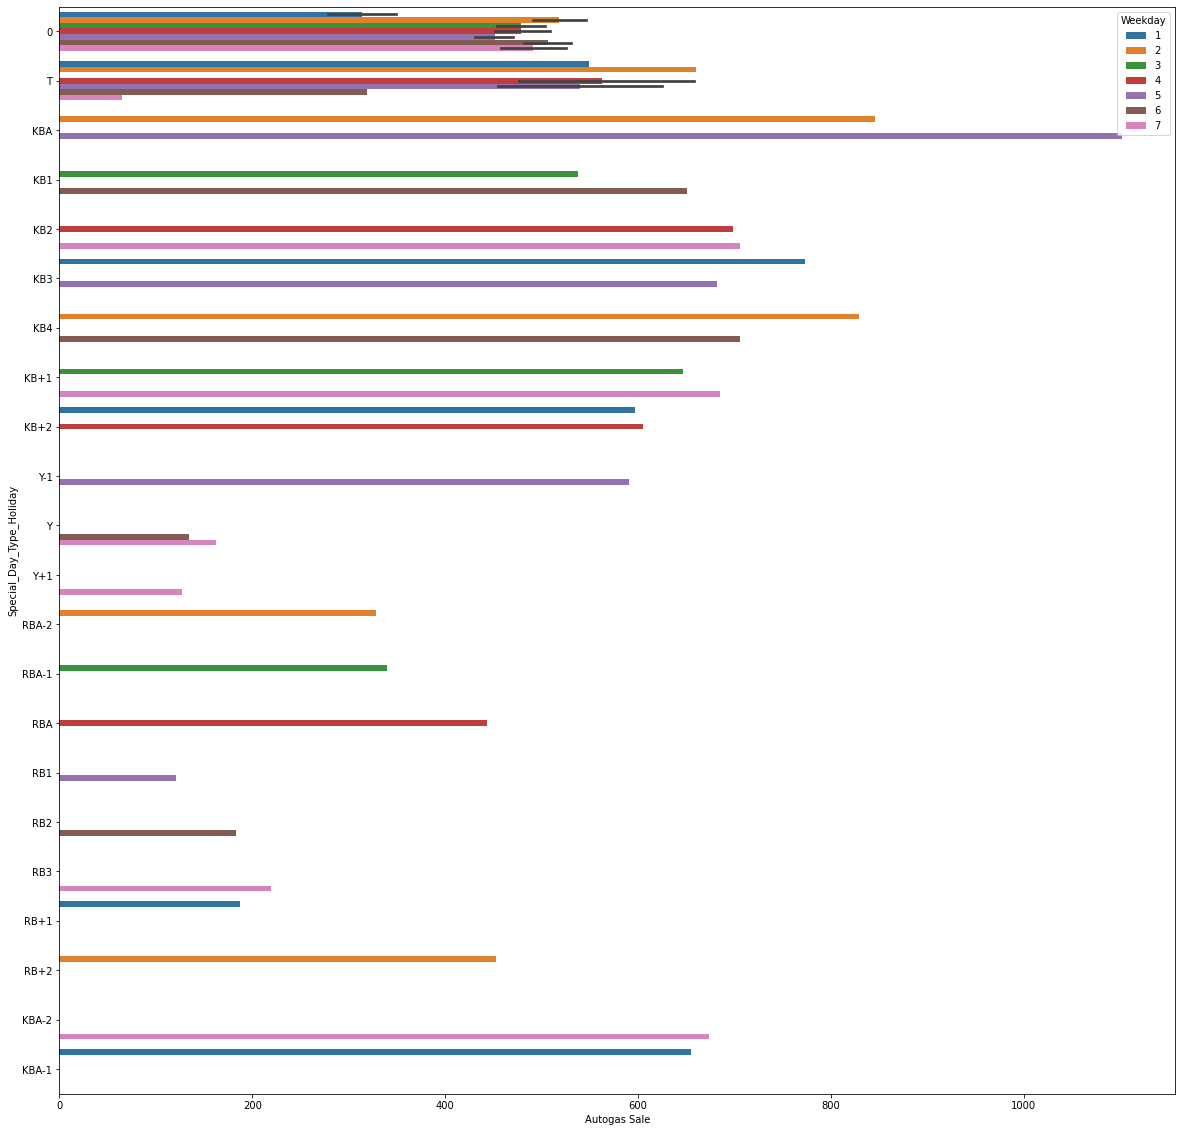

In [82]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(y="Special_Day_Type_Holiday",x='Autogas Sale',hue="Weekday",data=data);

<AxesSubplot:ylabel='Weekday'>

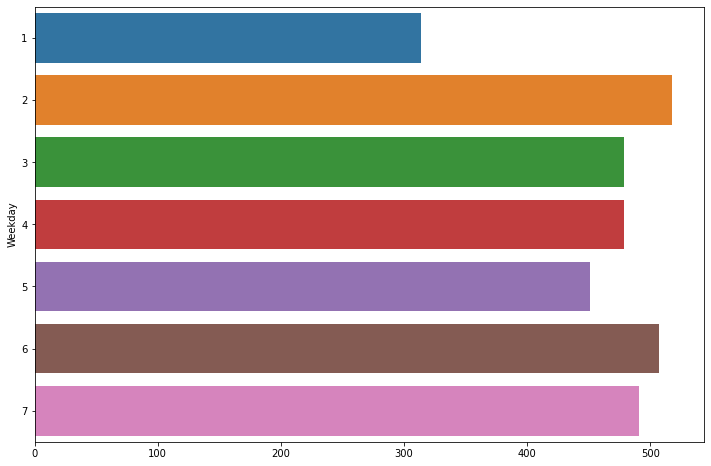

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
series4 = data.loc[data.Special_Day_Type_Holiday==0].groupby("Weekday").mean()["Autogas Sale"]
sns.barplot(x=series4.values,y=series4.index)

In [28]:
data.columns

Index(['Toptan Satis Miktar', 'Tuplu Satis Miktar', 'Dokme Satis Miktar',
       'Otogaz Satis Miktar', 'Toplam Satis Miktar', 'Limit',
       'Tüpraş Fiyat Değişikliği  TL/ton', 'Tüpraş Fiyat (OTV+Gelir)', 'Year',
       'Month', 'Day', 'Weekday', 'Special_Day_Type_Holiday',
       'Special_Day_Type_Month', 'Special_Day_Type_Zam',
       'Special_Day_Type_Indirim', 'Covid Hasta Sayisi', 'Covid Vefat Sayisi',
       'Vefat/Iyilesen', 'Otogaz-7', 'Otogaz-1', 'Toptan-7', 'Toptan-1',
       'Tuplu-7', 'Tuplu-1', 'Dokme-7', 'Dokme-1', 'Toplam-7', 'Toplam-1'],
      dtype='object')

C:\Users\ridvan\AppData\Local\Temp/ipykernel_30108/579834514.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


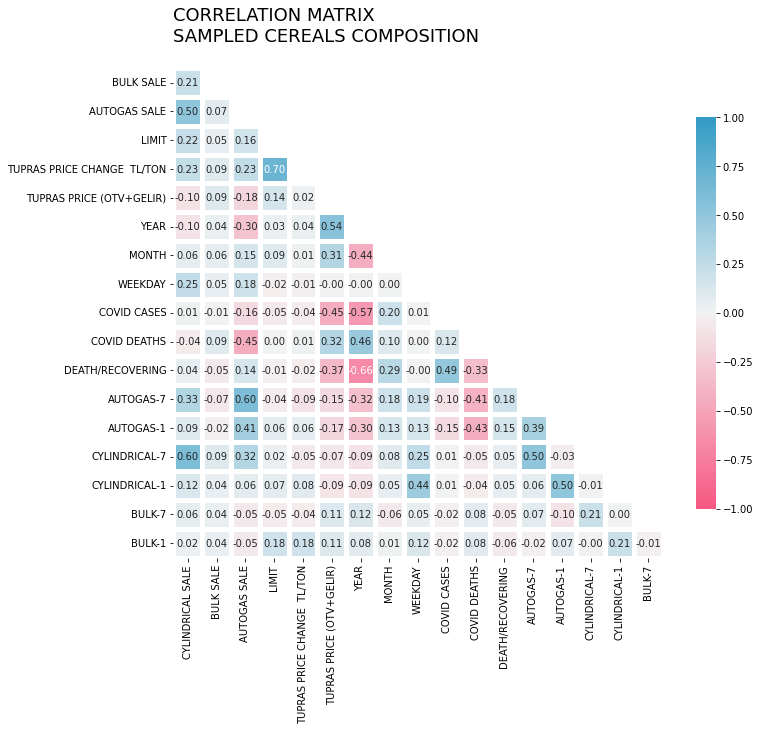

In [51]:
import seaborn as sb
df_corr = X_num.corr()

fig, ax = plt.subplots(figsize=(12, 9))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'CORRELATION MATRIX\nSAMPLED CEREALS COMPOSITION\n'
plt.title(title, loc='left', fontsize=18)
plt.show();

As we can predict when we look at the correlation table we see that there is a strong correlation among the sale quantities in each subsequent sale area which are wholesale, cylindrical sales, bulk LPG sale, otogas and total sale.Each subsequent sale amount is positively correlated with the prvious day and the precious week sales.

2020 was a special year because of the covid 19 and related restrictions. There is a significant negative correlation between the number of Covid 19 Cases or Number of Covid 19 Deaths or Death to Recovery Rate and otogas sales but indeed there is a postive correlation for the bulk LPG and cylinder LPG sales. During the increased number of Covid 19 cases people stayed home and come at home and it resulted with the icreased number of LPG usage. 

What is the importance of eact feature in our dataset?

To answer this quesion we will create a linear model to measure the coefficient weigths 

In [102]:
from sklearn.linear_model import LinearRegression

In [103]:
X.tail()

,Toptan Satis Miktar,Tuplu Satis Miktar,Dokme Satis Miktar,Otogaz Satis Miktar,Toplam Satis Miktar,Limit,Tüpraş Fiyat Değişikliği TL/ton,Tüpraş Fiyat (OTV+Gelir),Year,Month,...,Special_Day_Type_Month_A-1,Special_Day_Type_Month_A0,Special_Day_Type_Zam_Z,Special_Day_Type_Zam_Z+1,Special_Day_Type_Zam_Z-1,Special_Day_Type_Zam_Z-2,Special_Day_Type_Indirim_I,Special_Day_Type_Indirim_I+1,Special_Day_Type_Indirim_I-1,Special_Day_Type_Indirim_I-2
Tarih,,,,,,,,,,,,,,,,,,,,,
2022-01-10,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,11681.18,2022,1,...,0,0,0,0,0,1,0,0,0,0
2022-01-11,0.0,0.0,0.0,0.0,0.0,0.030677,453.45555,11681.18,2022,1,...,0,0,0,0,1,0,0,0,0,0
2022-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,12135.18,2022,1,...,0,0,1,0,0,0,0,0,0,0
2022-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,12135.18,2022,1,...,0,0,0,1,0,0,0,0,0,0
2022-01-14,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,12135.18,2022,1,...,0,0,0,0,0,0,0,0,0,0


In [92]:
data.columns

Index(['Cylindrical Sale', 'Bulk Sale', 'Autogas Sale', 'Limit',
       'TUPRAS Price Change  TL/ton', 'TUPRAS Price (OTV+Gelir)', 'Year',
       'Month', 'Weekday', 'Special_Day_Type_Holiday',
       'Special_Day_Type_Month', 'Special_Day_Type_Raise',
       'Special_Day_Type_Discount', 'Covid Cases', 'Covid Deaths',
       'Death/recovering', 'Autogas-7', 'Autogas-1', 'Cylindrical-7',
       'Cylindrical-1', 'Bulk-7', 'Bulk-1'],
      dtype='object')

In [99]:
%%time
X_sample = X.drop(columns=["Cylindrical Sale","Bulk Sale","Autogas Sale"], axis=1)
y = X["Autogas Sale"]
scaler=StandardScaler()
scaler.fit(X_sample)
X_scaled = pd.DataFrame(scaler.transform(X_sample), columns=X_sample.columns)
X_scaled.index=X_sample.index
X_scaled.tail(8)

Wall time: 16.7 ms


,Limit,TUPRAS Price Change TL/ton,TUPRAS Price (OTV+Gelir),Year,Month,Weekday,Covid Cases,Covid Deaths,Death/recovering,Autogas-7,...,Special_Day_Type_Month_A-1,Special_Day_Type_Month_A0,Special_Day_Type_Raise_Z,Special_Day_Type_Raise_Z+1,Special_Day_Type_Raise_Z-1,Special_Day_Type_Raise_Z-2,Special_Day_Type_Discount_I,Special_Day_Type_Discount_I+1,Special_Day_Type_Discount_I-1,Special_Day_Type_Discount_I-2
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,-0.157096,-0.084067,3.169833,2.61595,-1.904218,-0.497749,-0.81867,0.009969,-0.873205,-0.923350,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-05,-0.157096,-0.084067,3.169833,2.61595,-1.904218,0.002575,-0.81867,0.077685,-0.892437,-0.410300,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-06,-0.157096,-0.084067,3.169833,2.61595,-1.904218,0.502898,-0.81867,0.224401,-0.807333,0.047302,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-07,-0.157096,-0.084067,3.169833,2.61595,-1.904218,1.003222,-0.81867,0.235686,-0.858144,2.002155,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-08,-0.157096,-0.084067,3.169833,2.61595,-1.904218,1.503545,-0.81867,0.055113,-0.947498,-2.005167,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-09,-0.157096,-0.084067,3.169833,2.61595,-1.904218,-1.498396,-0.81867,0.416260,-0.889549,-1.408907,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-10,-0.157096,-0.084067,3.169833,2.61595,-1.904218,-0.998073,-0.81867,0.416260,-0.889549,-0.756052,...,-0.183543,-0.183543,-0.202661,-0.19803,-0.216052,4.724405,-0.101974,-0.101974,-0.101974,-0.101974
2022-01-11,2.538610,2.568958,3.169833,2.61595,-1.904218,-0.497749,-0.81867,0.416260,-0.889549,-0.716678,...,-0.183543,-0.183543,-0.202661,-0.19803,4.628507,-0.211667,-0.101974,-0.101974,-0.101974,-0.101974


In [100]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2, shuffle = True)

In [105]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_sample, y, test_size=0.2, shuffle = True)

lm_model = LinearRegression(normalize=True)

lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)

train_score=r2_score(y_train,lm_model.predict(X_train))
test_score=r2_score(y_test,y_pred)

In [106]:
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
0,Limit,-1271.635547,1271.635547
21,Special_Day_Type_Holiday_KBA,384.803156,384.803156
8,Death/recovering,-348.608006,348.608006
34,Special_Day_Type_Holiday_Y+1,-209.869312,209.869312
27,Special_Day_Type_Holiday_RB2,-207.216238,207.216238
22,Special_Day_Type_Holiday_KBA-1,190.975476,190.975476
19,Special_Day_Type_Holiday_KB3,133.452050,133.452050
29,Special_Day_Type_Holiday_RBA,128.716378,128.716378
44,Special_Day_Type_Discount_I+1,-125.364826,125.364826
38,Special_Day_Type_Month_A0,-119.419885,119.419885


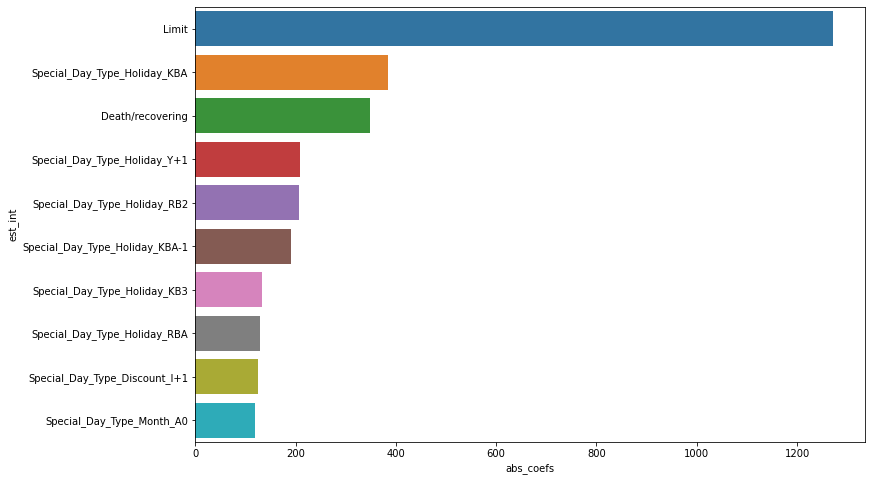

In [111]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="abs_coefs",y="est_int",data=coef_df.head(10));

According to the linear model coeeficients, LPG price change plays the biggest role in the prediction of otogas sales. As we discussed in the correlation table we see that previous day of Eid-al-Adha holiday play a very significant role in the precitipon of autogas sales.